In [1]:
"""
An implementation of Multi-Layer Perceptron (MLP) for fault pattern identification,
for Fault Detection and Identification Course, KNTU, Spring 2023.

Programmed by Ardavan Modarres
ardavan.modarres@email.kntu.ac.ir
* 2023-05-20: Initial coding
"""

In [ ]:
# Imports
import torch
import torch.nn.functional as F                    # Parameterless functions, like activation functions
from torch import optim                            # For optimizers like SGD, Adam, etc.
from torch import nn                               # All neural network modules
from torch.utils.data import DataLoader, Dataset   # dataset managment by creating mini batches etc.
from tqdm import tqdm                              # For progress bar!
import matplotlib.pyplot as plt                    # for plotting!
import numpy as np
import seaborn as sn

In [ ]:
!pip install torchmetrics
import torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 8.4 MB/s eta 0:00:00


## Generating a simple dataset

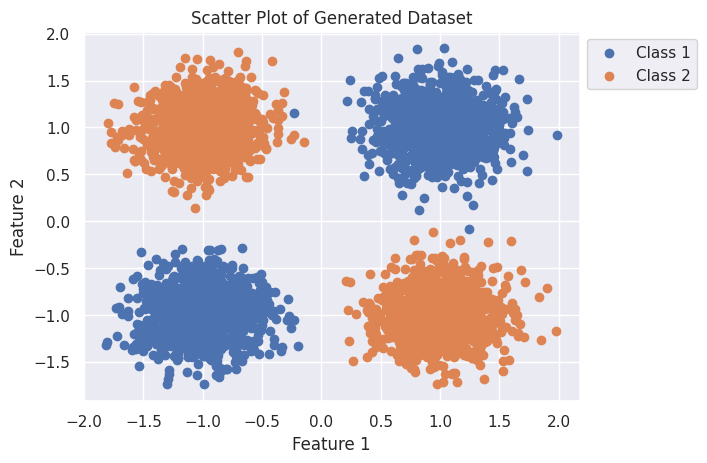

shape of x:  (4000, 2)
shape of y:  (4000,)


In [ ]:
mean1 = [1, 1]
mean2 = [-1, -1]
mean3 = [1, -1]
mean4 = [-1, 1]
cov = [[0.07, 0], [0, 0.07]]  # diagonal covariance

x1 = np.random.multivariate_normal(mean1, cov, 1000)
x2 = np.random.multivariate_normal(mean2, cov, 1000)
x3 = np.random.multivariate_normal(mean3, cov, 1000)
x4 = np.random.multivariate_normal(mean4, cov, 1000)

x = np.concatenate((x1, x2, x3, x4), axis=0)   # all dataset
y = np.zeros((4000))   # all labels
y[2000:] = 1

z1 = np.concatenate((x1, x2), axis=0)
z2 = np.concatenate((x3, x4), axis=0)

sn.set_theme(style="darkgrid")
plt.scatter(z1[:, 0], z1[:, 1])
plt.scatter(z2[:, 0], z2[:, 1])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Generated Dataset")
plt.legend(['Class 1', 'Class 2'], ncol=1, bbox_to_anchor=(1., 1.0), loc='upper left')
plt.show()

print("shape of x: ", x.shape)
print("shape of y: ", y.shape)

## Custom dataset class

In [ ]:
class XORdataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).to(torch.float32)
        self.y = torch.from_numpy(y).to(torch.long)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

ds = XORdataset(x, y)
print(len(ds))
print("Sample number 0 : ", ds[0])
print(ds[0][0], ds[0][1])

4000
Sample number 0 :  (tensor([1.1550, 0.6807]), tensor(0))
tensor([1.1550, 0.6807]) tensor(0)


## Berief review of Fully Connected Neural Network (MLP) and fc network definition in PyTorch

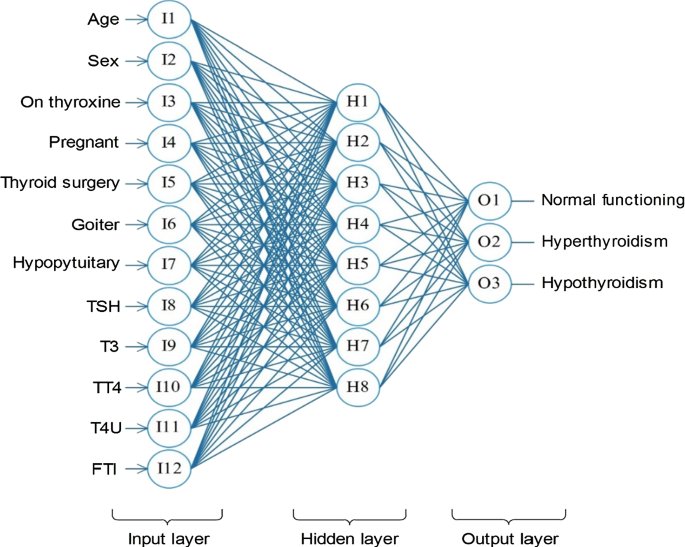

### Two simple examples:

#### Example 1:

In [ ]:
input = torch.randn(100, 500)
output = nn.Linear(500, 400)(input)
output = nn.Linear(400, 300)(output)
output = nn.Linear(300, 200)(output)
output = nn.Linear(200, 100)(output)
output = nn.Linear(100, 4)(output)
print(output.size())

torch.Size([100, 4])


#### Example 2:

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # defining layers and activation functions
        self.fc1 = nn.Linear(500, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 200)
        self.fc4 = nn.Linear(200, 100)
        self.fc5 = nn.Linear(100, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

input = torch.randn(100, 500)
model = MLP()
output = model(input)
print(output.shape)

torch.Size([100, 4])


## Defining Fully Connected Neural Network

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        # defining layers and activation functions
        self.fc1 = nn.Linear(input_size, 5)
        self.fc2 = nn.Linear(5, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Setting hyper parameters

In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 2
num_classes = 2
learning_rate = 4e-3
batch_size = 64
num_epochs = 25

## Instanciating custom dataset and defining data loaders

In [ ]:
dataset = XORdataset(x, y)
train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [ ]:
# Loop through the dataset
for c, (x, y) in enumerate(train_loader):
  if c == 0:
      print("shape of x : ", x.shape)
      print("shape of y : ", y.shape)
  else:
      break

shape of x :  torch.Size([64, 2])
shape of y :  torch.Size([64])


## Instanciating a model and defining data loss function and optimizer

In [ ]:
# Initialize network
model = MLP(input_size=input_size, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Defining useful function for training procedure


In [ ]:
def get_info(model, loader):
  batch_loss = []
  epoch_loss = []
  temp_loss = []
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for (data, targets) in loader:
      # Get data to device
      data = data.to(device=device)
      targets = targets.to(device=device)

      # Forward
      logits = model(data)
      _, predictions = logits.max(1)
      loss = criterion(logits, targets)

      # Taking record of losses
      batch_loss.append(loss.item())

      # Check how many we got correct
      num_correct += (predictions == targets).sum()
      # Keep track of number of samples
      num_samples += predictions.size(0)
  model.train()
  return (num_correct/num_samples).item(), sum(batch_loss)/len(batch_loss)

In [ ]:
# Train Network
def Train(model, device, criterion, optimizer, num_epochs):
  train_loss = []
  validation_loss = []
  train_acc = []
  validation_acc = []
  for epoch in range(num_epochs):
      for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
          # Get data to device
          data = data.to(device=device)
          targets = targets.to(device=device)

          # Forward
          logits = model(data)
          loss = criterion(logits, targets)

          # Backward
          optimizer.zero_grad()
          loss.backward()

          # Gradient descent or adam step
          optimizer.step()

      # Taking record of losses
      tr_acc, tr_loss = get_info(model, train_loader)
      val_acc, val_loss = get_info(model, validation_loader)
      train_loss.append(tr_loss)
      validation_loss.append(val_loss)
      train_acc.append(tr_acc)
      validation_acc.append(val_acc)

  plt.figure(figsize=(10, 6))
  #plot 1:
  plt.subplot(1, 2, 1)
  plt.plot(train_acc)
  plt.plot(validation_acc)
  plt.title("Accuracy")
  plt.legend(['train accuracy', 'validation accuracy'])
  #plot 2:
  plt.subplot(1, 2, 2)
  plt.plot(train_loss)
  plt.plot(validation_loss)
  plt.title("Loss")
  plt.legend(['train loss', 'validation loss'])
  plt.suptitle("Performance")
  plt.show()

## Training the network

100%|██████████| 50/50 [00:00<00:00, 452.67it/s]


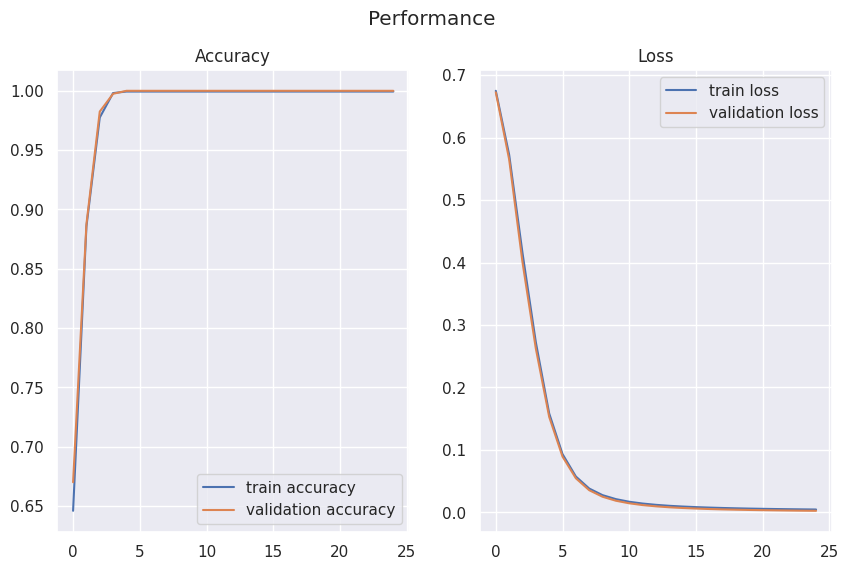

In [ ]:
Train(model, device, criterion, optimizer, num_epochs)

## A simple test

In [ ]:
# Check accuracy on training & test
def get_acc(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Forward pass
            logits = model(x)
            _, predictions = logits.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

In [ ]:
# Check accuracy on training & test
print(f"Accuracy on training set: {get_acc(train_loader, model)*100:.2f}")
print(f"Accuracy on training set: {get_acc(validation_loader, model)*100:.2f}")
print(f"Accuracy on test set: {get_acc(test_loader, model)*100:.2f}")

Accuracy on training set: 99.94
Accuracy on training set: 100.00
Accuracy on test set: 100.00


In [ ]:
model.eval()
with torch.no_grad():
    # Loop through the data
    for c, (x, y) in enumerate(test_loader):
      # Move data to device
      x = x.to(device=device)
      y = y.to(device=device)

      # Forward pass
      logits = model(x)
      _, predictions = logits.max(1)

      if torch.all(y == predictions).item():
        print("All Predictions and Labels in current mini-batch of test dataset are completely.")
      # print(torch.all(y == predictions))

All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.


Accuracy Of Model On Test Data Is :  tensor(100.)
Percision Of Model On Test Data Is :  tensor(100.)
Recall Of Model On Test Data Is :  tensor(100.)
F1-Score Of Model On Test Data Is :  tensor(100.)

Confusion Matrix Of Model On Test Data Is : 


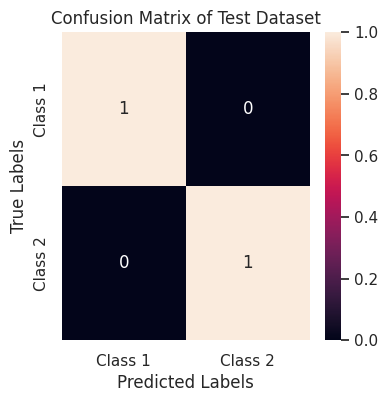

In [ ]:
predictions = torch.zeros(len(test_set))
targets = torch.zeros(len(test_set))
pointer = 0

model.eval()
with torch.no_grad():
  for x, y in test_loader:
    logits = model(x)
    _, preds = logits.max(1)
    predictions[pointer: pointer+x.shape[0]] = preds
    targets[pointer: pointer+x.shape[0]] = y
    pointer+=x.shape[0]


  accuracy = torchmetrics.Accuracy(task="multiclass", average='macro', num_classes=2)
  precision = torchmetrics.Precision(task="multiclass", average='macro', num_classes=2)
  recall = torchmetrics.Recall(task="multiclass", average='macro', num_classes=2)
  f1score = torchmetrics.F1Score(task="multiclass", average='macro', num_classes=2)
  confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=2)

  a = accuracy(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  p = precision(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  r = recall(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  f1s = f1score(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  cm = confmat(predictions, targets.reshape(-1,).to(dtype=torch.int64))


  print("Accuracy Of Model On Test Data Is : ", 100*a)
  print("Percision Of Model On Test Data Is : ", 100*p)
  print("Recall Of Model On Test Data Is : ", 100*r)
  print("F1-Score Of Model On Test Data Is : ", 100*f1s)
  print("")

  print("Confusion Matrix Of Model On Test Data Is : ")
  cm = cm/cm.sum(dim=1).reshape(2,1)
  plt.figure(figsize = (4, 4))
  sn.heatmap(cm, annot=True, xticklabels=['Class 1', 'Class 2'],
            yticklabels=['Class 1', 'Class 2'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title("Confusion Matrix of Test Dataset")
  plt.show()